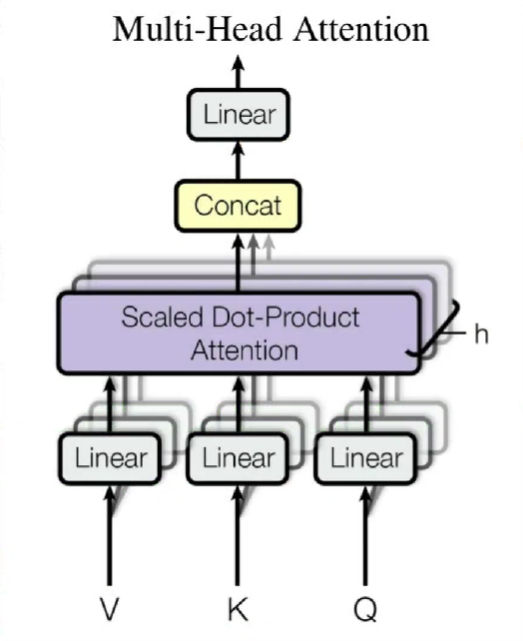

In [1]:
import numpy as np
import tensorflow as tf

class BaseAttention(tf.keras.layers.Layer):
    """
    Base class for all attention layers. It contains the common functionality of all attention layers.
    This layer contains a MultiHeadAttention layer, a LayerNormalization layer and an Add layer.
    It is used as a base class for the GlobalSelfAttention, CausalSelfAttention and CrossAttention layers.
    And it is not intended to be used directly.

    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        mha (tf.keras.layers.MultiHeadAttention): The MultiHeadAttention layer.
        layernorm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
        add (tf.keras.layers.Add): The Add layer.
    """
    def __init__(self, **kwargs: dict):
        """
        Constructor of the BaseAttention layer.

        Args:
            **kwargs: Additional keyword arguments that are passed to the MultiHeadAttention layer, e.g.
            num_heads (number of heads), key_dim (dimensionality of the key space), etc.
        """
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

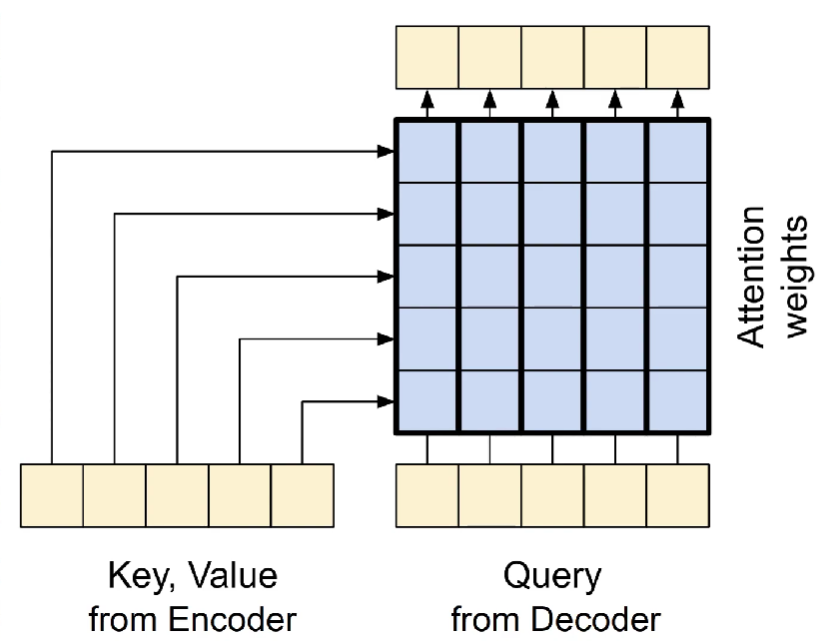

In [2]:
class CrossAttention(BaseAttention):
    """
    A class that implements the cross-attention layer by inheriting from the BaseAttention class.
    This layer is used to process two different sequences and attends to the context sequence while processing the query sequence.

    Methods:
    --------
    call: Performs the forward pass of the layer.

    Attributes:
    -----------
    mha (tf.keras.layers.MultiHeadAttention): The MultiHeadAttention layer.
    layernorm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
    add (tf.keras.layers.Add): The Add layer.
    """

    def call(self, x: tf.Tensor, context: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the cross-attention operation.

        Args:
        -----
        x (tf.Tensor): The query (expected Transformer results) sequence of shape (batch_size, seq_length, d_model).
        context (tf.Tensor): The context (inputs to the Encoder layer) sequence of shape (batch_size, seq_length, d_model).

        Returns:
        --------
        tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        attn_output, attn_scores = self.mha(query=x, key=context, value=context, return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

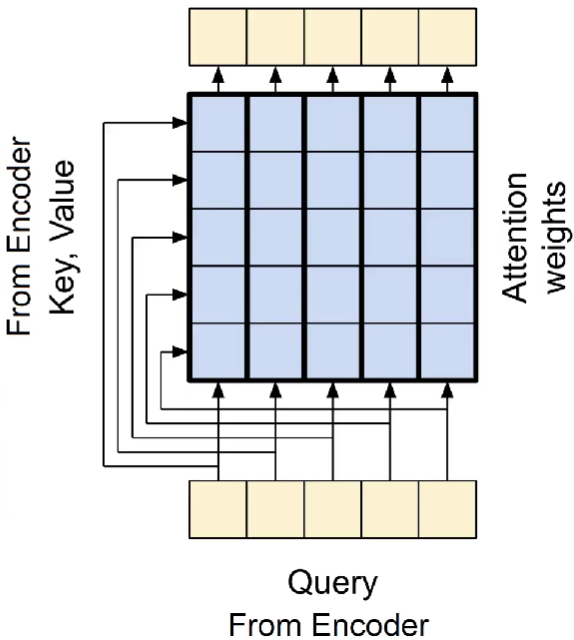

In [ ]:
class GlobalSelfAttention(BaseAttention):
    """
    A class that implements the global self-attention layer by inheriting from the BaseAttention class.
    This layer is used to process a single sequence and attends to all the tokens in the sequence.

    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        mha (tf.keras.layers.MultiHeadAttention): The MultiHeadAttention layer.
        layernorm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
        add (tf.keras.layers.Add): The Add layer.
    """
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the global self-attention operation.

        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length, d_model).

        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

![Screenshot 2025-01-15 085850.png](<attachment:Screenshot 2025-01-15 085850.png>)
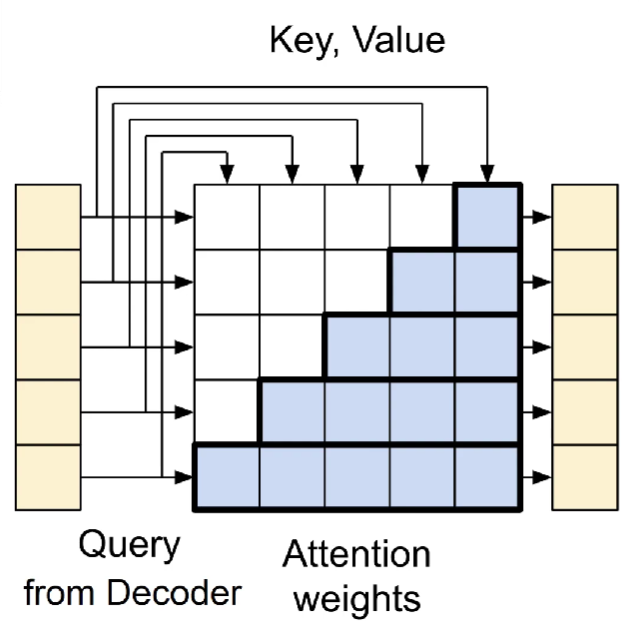

In [ ]:
class CausalSelfAttention(BaseAttention):
    """
    Call self-attention on the input sequence, ensuring that each position in the 
    output depends only on previous positions (i.e. a causal model).

    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        mha (tf.keras.layers.MultiHeadAttention): The MultiHeadAttention layer.
        layernorm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
        add (tf.keras.layers.Add): The Add layer.
    """
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the causal self-attention operation.

        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length, d_model).

        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        attn_output = self.mha(query=x, value=x, key=x, use_causal_mask=True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x